## Búsqueda Local Estocástica 
### Ejemplo con SimpleAI

In [7]:
import numpy as np
import pandas as pd

In [8]:
import pickle
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)
stock_series = stock_data['ITX'].close.loc['2014':]

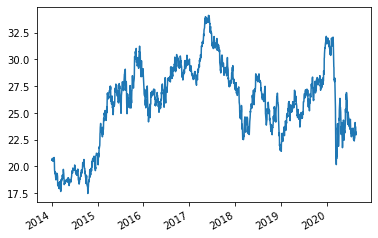

In [9]:
stock_series.plot()

____

In [10]:
from simpleai.search import SearchProblem, beam, hill_climbing_random_restarts

In [11]:
from stoparam_opt import StochasticOsc

Para utilizar los algoritmos de búsqueda local estocástica tenemos que implementar el modelo de estados, que será específico de cada problema.  Se parte de heredar la clase *SearchProblem* y se tienen que implementar los siguientes 
métodos.
- <tt>actions</tt>: Dado un estado debe retornar una lista  de acciones que son aplicables en dicho estado. 
- <tt>result</tt>: Dado un estado y el nombre de una acción calcula el estado resultante al aplicar los efectos
de la acción
- <tt>value</tt>: La función de evaluación del estado


Para ver más detalles del uso de la librería con búsqueda local, se puede consultar la documentación en la 
sección de [local search](https://simpleai.readthedocs.io/en/latest/local_search_problems.html)

___

In [12]:
def rnd_state():
    obought_space = np.linspace(0.51,0.98,48)
    osold_space = np.linspace(0.02,0.49,48)
    win_space = np.arange(10,120)
    lag_space = np.arange(1,50)

    win = np.random.choice(win_space)
    avail_lag = lag_space[lag_space < win]

    state =  {
        'win': win,
        'lag': np.random.choice(avail_lag), 
        'obought':np.random.choice(obought_space), 
        'osold':np.random.choice(osold_space)
    }
    print("RND Generated", state)
    return state

In [13]:
rnd_state()

RND Generated {'win': 33, 'lag': 9, 'obought': 0.77, 'osold': 0.28}


{'win': 33, 'lag': 9, 'obought': 0.77, 'osold': 0.28}

In [14]:
class StoOpt(SearchProblem):
    def __init__(self, vseries, initial_state=None):
        self.vseries = vseries
        if initial_state is None:
            initial_state = rand_state()
        SearchProblem.__init__(self, initial_state=initial_state)
        
    def actions(self, state):
        s = state
        min_win, max_win=10, 120
        min_lag, max_lag=1, 50
        min_ob, max_ob=0.51,0.98
        min_os, max_os=0.02,0.49

        # win=14, lag=3, obought=0.8, osold=0.2
        succ = []
        if s['win'] < max_win:
            succ.append('inc win')
        if s['win'] > min_win:
            succ.append('dec win')
        if s['lag'] < max_lag and s['lag']+1 < s['win']:
            succ.append('inc lag')
        if s['lag'] < max_lag:
            succ.append('dec lag')
        if s['obought'] < max_ob:
            succ.append('inc obought')
        if s['obought'] > min_ob:
            succ.append('dec obought')
        if s['osold'] < max_os:
            succ.append('inc osold')
        if s['osold'] > min_os:
            succ.append('dec osold')
            
        return succ
    
    def result(self, state, action):
        par_action = action.split()
        move = par_action[0]
        iparam = par_action[1]
        
        new_state = state.copy()
        if iparam in ['lag', 'win']:
            delta = 1
        elif iparam in ['obought', 'osold']:
            delta = 0.02
        
        if move == 'dec':
            delta = -delta
            
        new_state[iparam] = new_state[iparam] + delta
        
        return new_state

    def value (self, state):
        val = StochasticOsc.backtest_so_returns(vseries=self.vseries, **state)
        return val
    
    def generate_random_state(self):
        return rnd_state()

Se construye el problema con nuestra nueva clase definida

In [15]:
init_state = rnd_state()
init_state

RND Generated {'win': 44, 'lag': 28, 'obought': 0.61, 'osold': 0.13}


{'win': 44, 'lag': 28, 'obought': 0.61, 'osold': 0.13}

In [16]:
problem = StoOpt(vseries=stock_series, initial_state=init_state)

el resultado de ejecutar el algoritmo es una estructura de datos de la que podemos
sacar el estado final y la evaluación de dicho estado

In [17]:
result = hill_climbing_random_restarts(problem, restarts_limit=5)

RND Generated {'win': 91, 'lag': 20, 'obought': 0.8400000000000001, 'osold': 0.1}
RND Generated {'win': 42, 'lag': 39, 'obought': 0.56, 'osold': 0.28}
RND Generated {'win': 109, 'lag': 21, 'obought': 0.77, 'osold': 0.25}
RND Generated {'win': 44, 'lag': 30, 'obought': 0.75, 'osold': 0.15}
RND Generated {'win': 63, 'lag': 4, 'obought': 0.72, 'osold': 0.48000000000000004}


El **estado final**

In [18]:
result.state

{'win': 108, 'lag': 20, 'obought': 0.79, 'osold': 0.25}

La evaluación del mejor estado

In [19]:
result.value

0.47131127340843704

_____

### Ejercicios Propuestos
1. Optimizar los parámetros, pero ahora utilizando el hill_climbing_stochastic y el beam search
2. Cambiar la clase StoOpt para contar los estados generados